In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim

In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.99MB/s]


In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

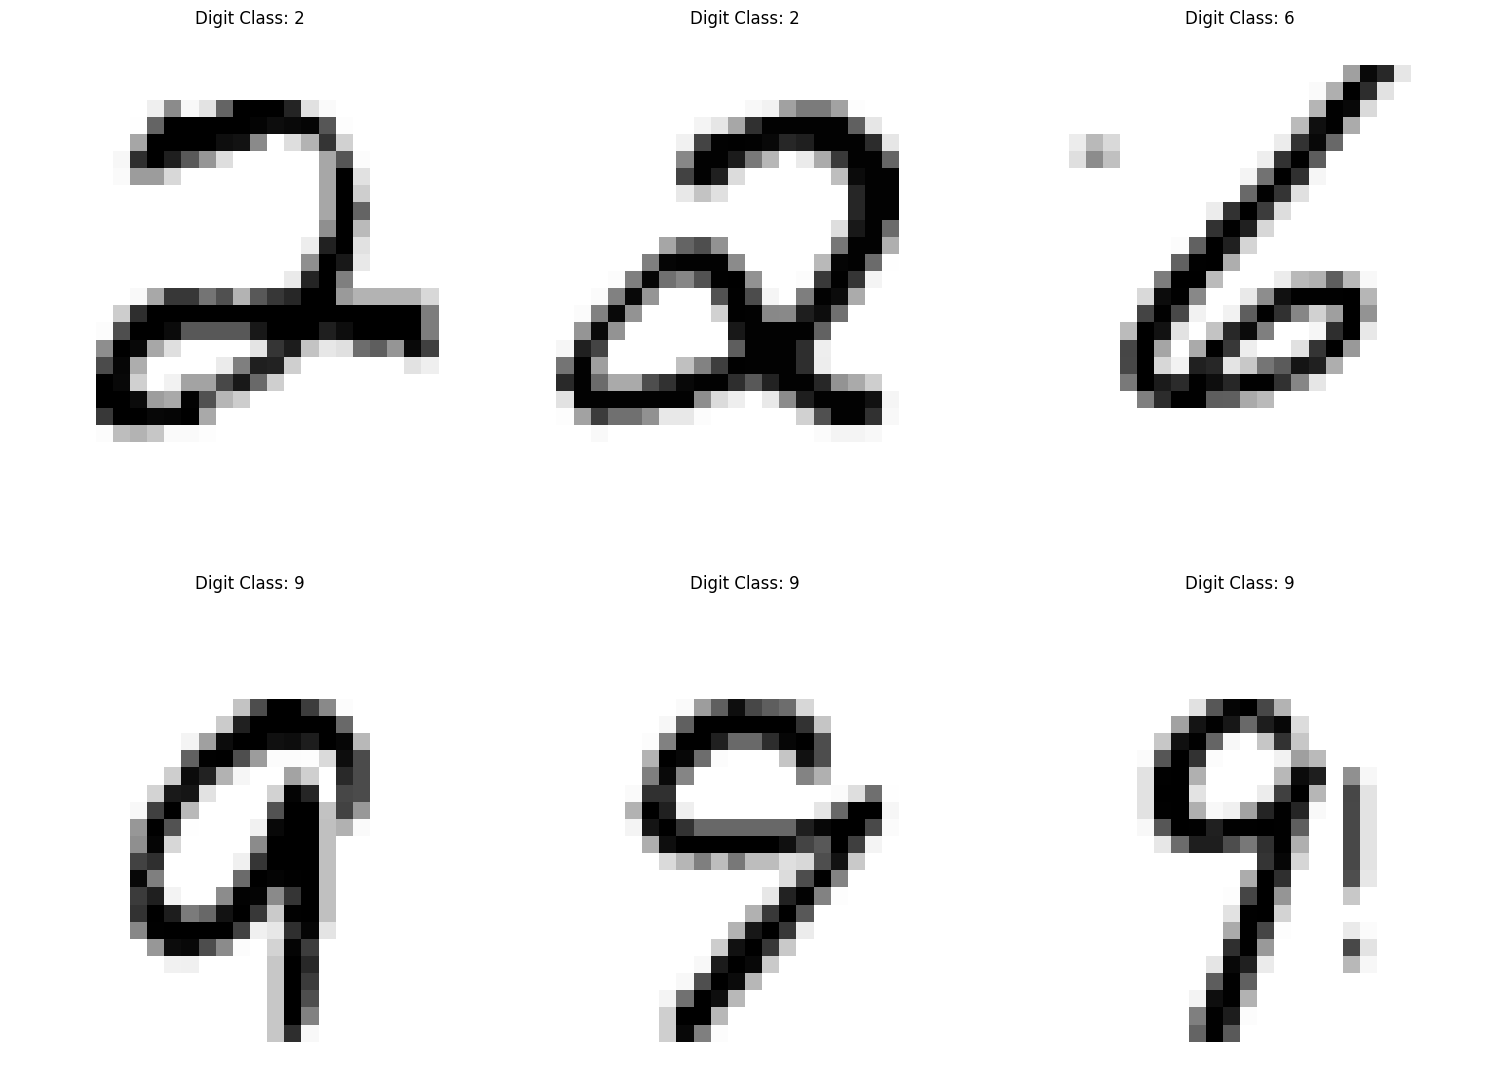

In [4]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [5]:
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [6]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     target_accuracy,
                     scheduler= None
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0.0
        train_total= 0.0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)


        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100


        train_loss_history.append(running_train_loss.item())
        val_loss_history.append(running_val_loss.item())
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss.item():.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss.item():.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("-" * 50)

        if val_acc >= target_accuracy:
            print(f"Stopping training. Target accuracy reached at epoch {epoch + 1}")
            break

        if scheduler:
            scheduler.step()

    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


In [7]:
torch.manual_seed(42)
LEARNING_RATE_ADAM= 0.008
LEARNING_RATE_SGD= 0.01
TARGET_ACCURACY= 97
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

control_adam_model= TinyMLP()
control_sgd_model= TinyMLP()
sgd_optim_model= TinyMLP()
momentum_optim_model= TinyMLP()
adam_optim_model= TinyMLP()

control_adam_optimizer= optim.Adam(control_adam_model.parameters(), lr= LEARNING_RATE_ADAM)
control_sgd_optimizer= optim.SGD(control_sgd_model.parameters(), lr= LEARNING_RATE_SGD)
sgd_optimizer= optim.SGD(sgd_optim_model.parameters(), lr= LEARNING_RATE_SGD)
momentum_optimizer= optim.SGD(momentum_optim_model.parameters(), lr= LEARNING_RATE_SGD, momentum= 0.9)
adam_optimizer= optim.Adam(adam_optim_model.parameters(), lr= LEARNING_RATE_ADAM)

sgd_scheduler= optim.lr_scheduler.CosineAnnealingLR(sgd_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
momentum_scheduler= optim.lr_scheduler.CosineAnnealingLR(momentum_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
adam_scheduler= optim.lr_scheduler.CosineAnnealingLR(adam_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)

print(f"Control Adam Model Training Starting...")
print(f"-"*80)
control_adam_model.to(device)
control_adam_metrics= train_eval_model(model= control_adam_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= control_adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"Control SGD Model Training Starting...")
print(f"-"*80)
control_sgd_model.to(device)
control_sgd_metrics= train_eval_model(model= control_sgd_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= control_sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"-"*80)
print(f"SGD Model Training Starting...")
print(f"-"*80)
sgd_optim_model.to(device)
sgd_model_metrics= train_eval_model(model= sgd_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY,
                                scheduler= sgd_scheduler)
print(f"-"*80)
print(f"Momentum Model Training Starting")
print(f"-"*80)
momentum_optim_model.to(device)
momentum_model_metrics= train_eval_model(model= momentum_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= momentum_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"-"*80)
print(f"Adam Training Starting")
print(f"-"*80)
adam_optim_model.to(device)
adam_model_metrics= train_eval_model(model= adam_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY,
                                scheduler= adam_scheduler)

print(f"-"*80)

Control Adam Model Training Starting...
--------------------------------------------------------------------------------
Epoch 1/30 
----------
Train Loss: 0.2577
Train Accuracy: 92.48%
Val Loss: 0.1690
Val Accuracy: 95.54%
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.1634
Train Accuracy: 95.58%
Val Loss: 0.1675
Val Accuracy: 95.32%
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.1358
Train Accuracy: 96.36%
Val Loss: 0.1537
Val Accuracy: 96.10%
--------------------------------------------------
Epoch 4/30 
----------
Train Loss: 0.1224
Train Accuracy: 96.80%
Val Loss: 0.1498
Val Accuracy: 96.46%
--------------------------------------------------
Epoch 5/30 
----------
Train Loss: 0.1135
Train Accuracy: 97.08%
Val Loss: 0.1884
Val Accuracy: 95.70%
--------------------------------------------------
Epoch 6/30 
----------
Train Loss: 0.1027
Train Accuracy: 97.41%
Val Loss: 0.1602
Val Accuracy: 96.56%
------

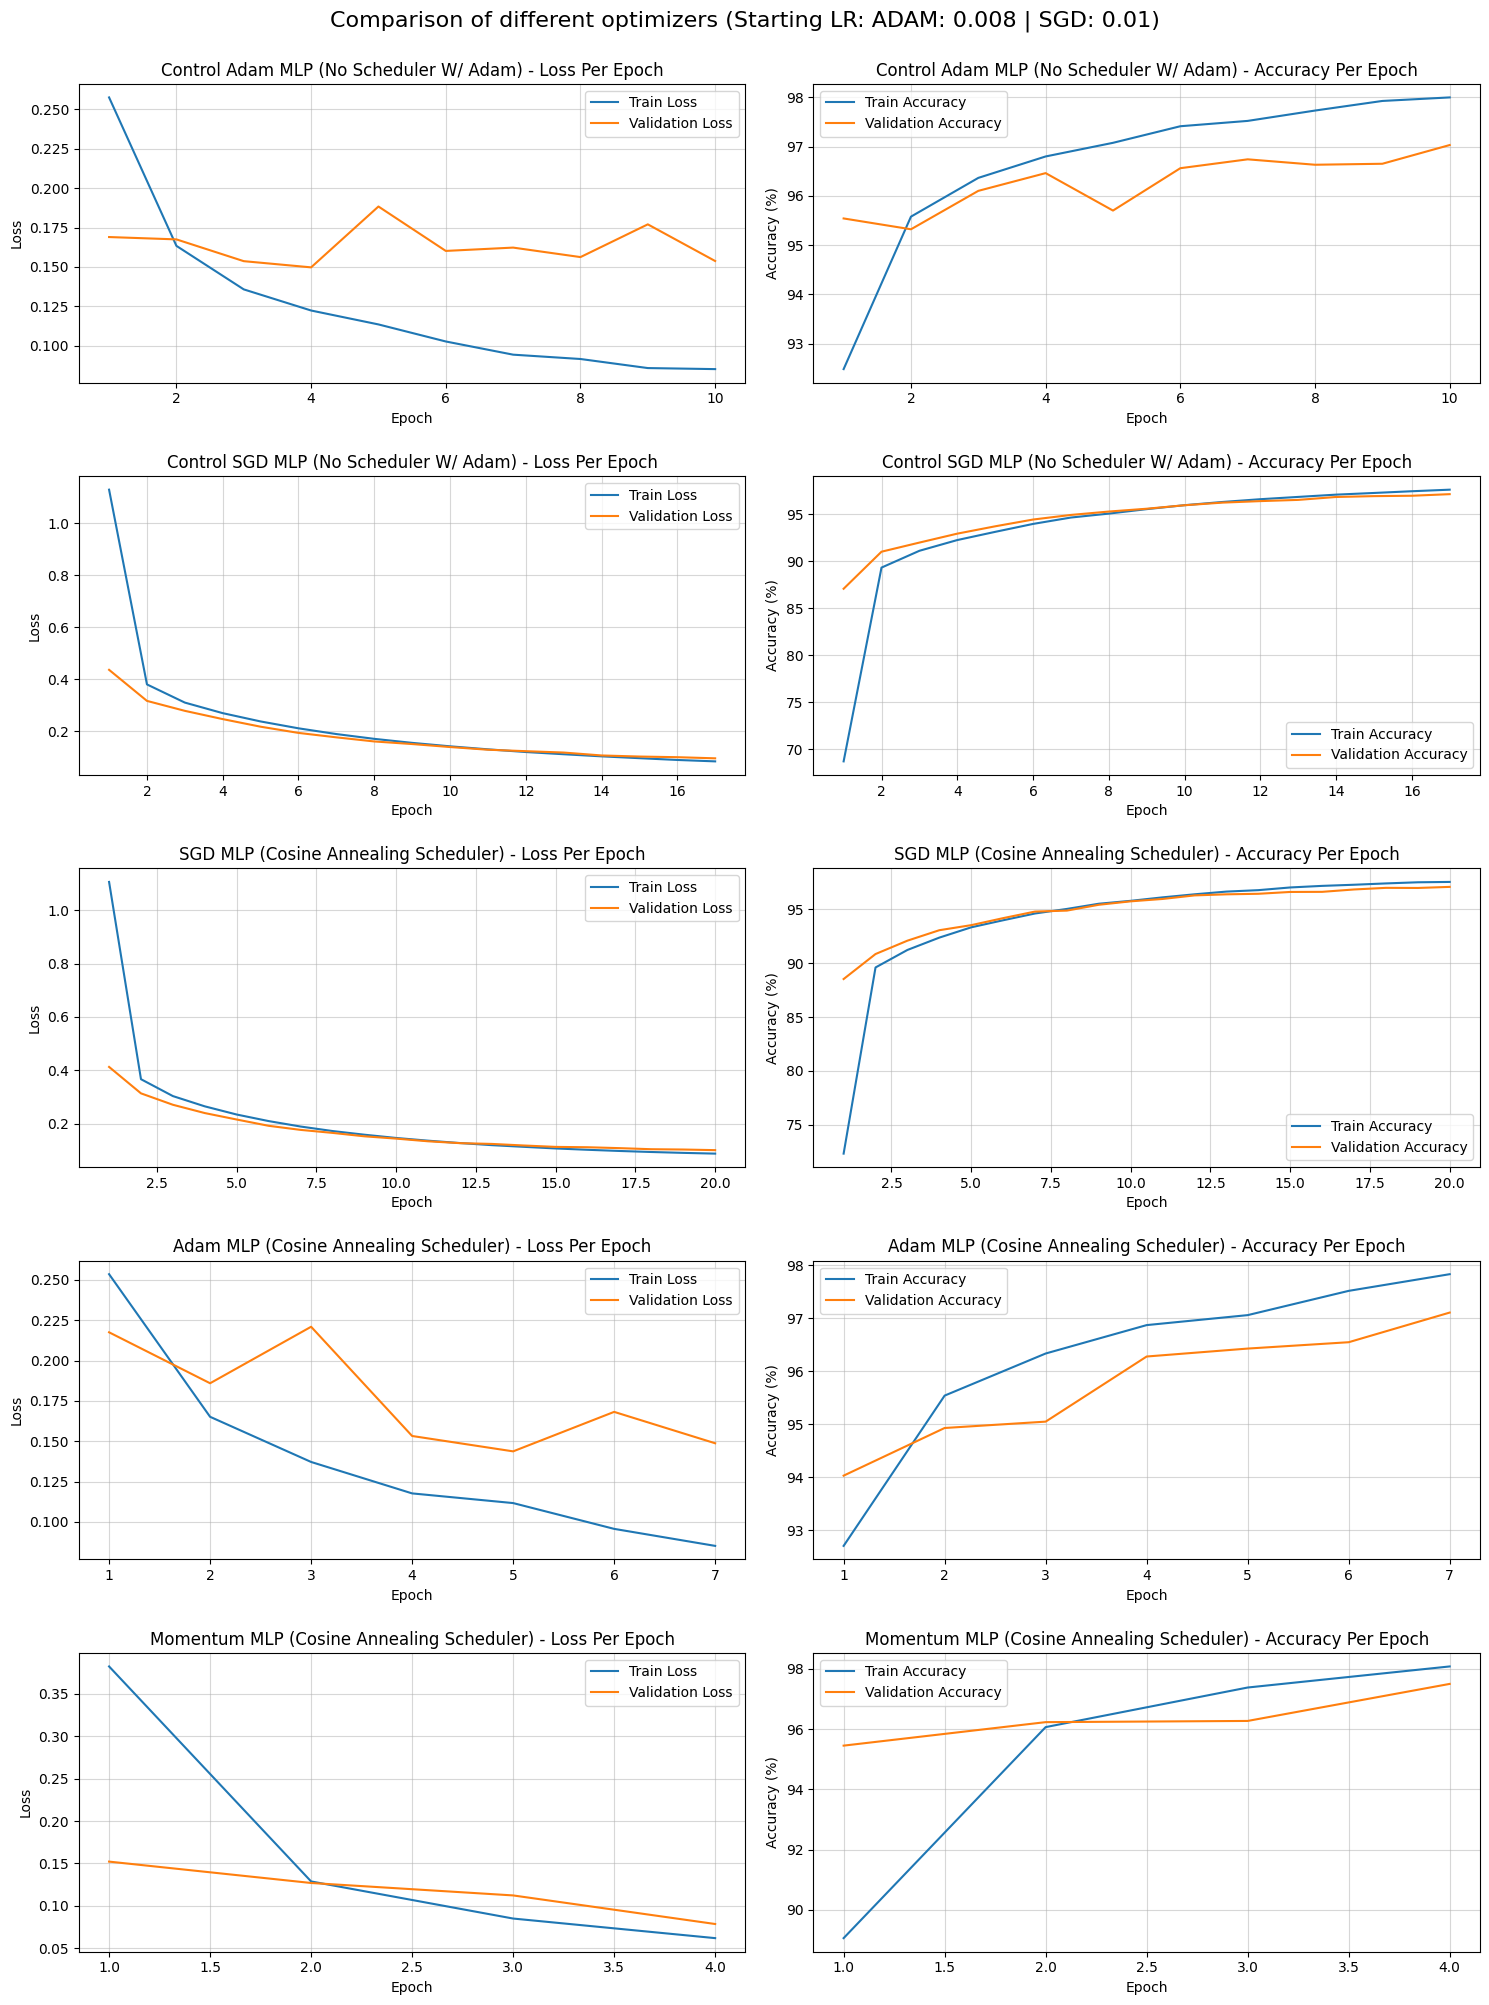

In [8]:
# Create figure with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Data to plot (model metrics)
models_data = [
    (control_adam_metrics, "Control Adam MLP (No Scheduler W/ Adam)"),
    (control_sgd_metrics, "Control SGD MLP (No Scheduler W/ Adam)"),
    (sgd_model_metrics, "SGD MLP (Cosine Annealing Scheduler)"),
    (adam_model_metrics, "Adam MLP (Cosine Annealing Scheduler)"),
    (momentum_model_metrics, "Momentum MLP (Cosine Annealing Scheduler)")
]

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"Comparison of different optimizers (Starting LR: ADAM: {LEARNING_RATE_ADAM} | SGD: {LEARNING_RATE_SGD})",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()

In [9]:
torch.manual_seed(42)
LEARNING_RATE_ADAM= 0.01
LEARNING_RATE_SGD= 0.1
TARGET_ACCURACY= 97
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

control_adam_model= TinyMLP()
control_sgd_model= TinyMLP()
sgd_optim_model= TinyMLP()
momentum_optim_model= TinyMLP()
adam_optim_model= TinyMLP()

control_adam_optimizer= optim.Adam(control_adam_model.parameters(), lr= LEARNING_RATE_ADAM)
control_sgd_optimizer= optim.SGD(control_sgd_model.parameters(), lr= LEARNING_RATE_SGD)
sgd_optimizer= optim.SGD(sgd_optim_model.parameters(), lr= LEARNING_RATE_SGD)
momentum_optimizer= optim.SGD(momentum_optim_model.parameters(), lr= LEARNING_RATE_SGD, momentum= 0.9)
adam_optimizer= optim.Adam(adam_optim_model.parameters(), lr= LEARNING_RATE_ADAM)

sgd_scheduler= optim.lr_scheduler.CosineAnnealingLR(sgd_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
momentum_scheduler= optim.lr_scheduler.CosineAnnealingLR(momentum_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
adam_scheduler= optim.lr_scheduler.CosineAnnealingLR(adam_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)

print(f"Control Adam Model Training Starting...")
print(f"-"*80)
control_adam_model.to(device)
control_adam_metrics= train_eval_model(model= control_adam_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= control_adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"Control SGD Model Training Starting...")
print(f"-"*80)
control_sgd_model.to(device)
control_sgd_metrics= train_eval_model(model= control_sgd_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= control_sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"-"*80)
print(f"SGD Model Training Starting...")
print(f"-"*80)
sgd_optim_model.to(device)
sgd_model_metrics= train_eval_model(model= sgd_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY,
                                scheduler= sgd_scheduler)
print(f"-"*80)
print(f"Momentum Model Training Starting")
print(f"-"*80)
momentum_optim_model.to(device)
momentum_model_metrics= train_eval_model(model= momentum_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= momentum_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY)
print(f"-"*80)
print(f"Adam Training Starting")
print(f"-"*80)
adam_optim_model.to(device)
adam_model_metrics= train_eval_model(model= adam_optim_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                target_accuracy= TARGET_ACCURACY,
                                scheduler= adam_scheduler)

print(f"-"*80)

Control Adam Model Training Starting...
--------------------------------------------------------------------------------
Epoch 1/30 
----------
Train Loss: 0.2738
Train Accuracy: 92.15%
Val Loss: 0.1996
Val Accuracy: 95.17%
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.1953
Train Accuracy: 94.92%
Val Loss: 0.2004
Val Accuracy: 95.35%
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.1612
Train Accuracy: 95.86%
Val Loss: 0.1622
Val Accuracy: 95.84%
--------------------------------------------------
Epoch 4/30 
----------
Train Loss: 0.1416
Train Accuracy: 96.47%
Val Loss: 0.1722
Val Accuracy: 96.03%
--------------------------------------------------
Epoch 5/30 
----------
Train Loss: 0.1324
Train Accuracy: 96.70%
Val Loss: 0.1974
Val Accuracy: 95.38%
--------------------------------------------------
Epoch 6/30 
----------
Train Loss: 0.1244
Train Accuracy: 96.96%
Val Loss: 0.1387
Val Accuracy: 96.46%
------

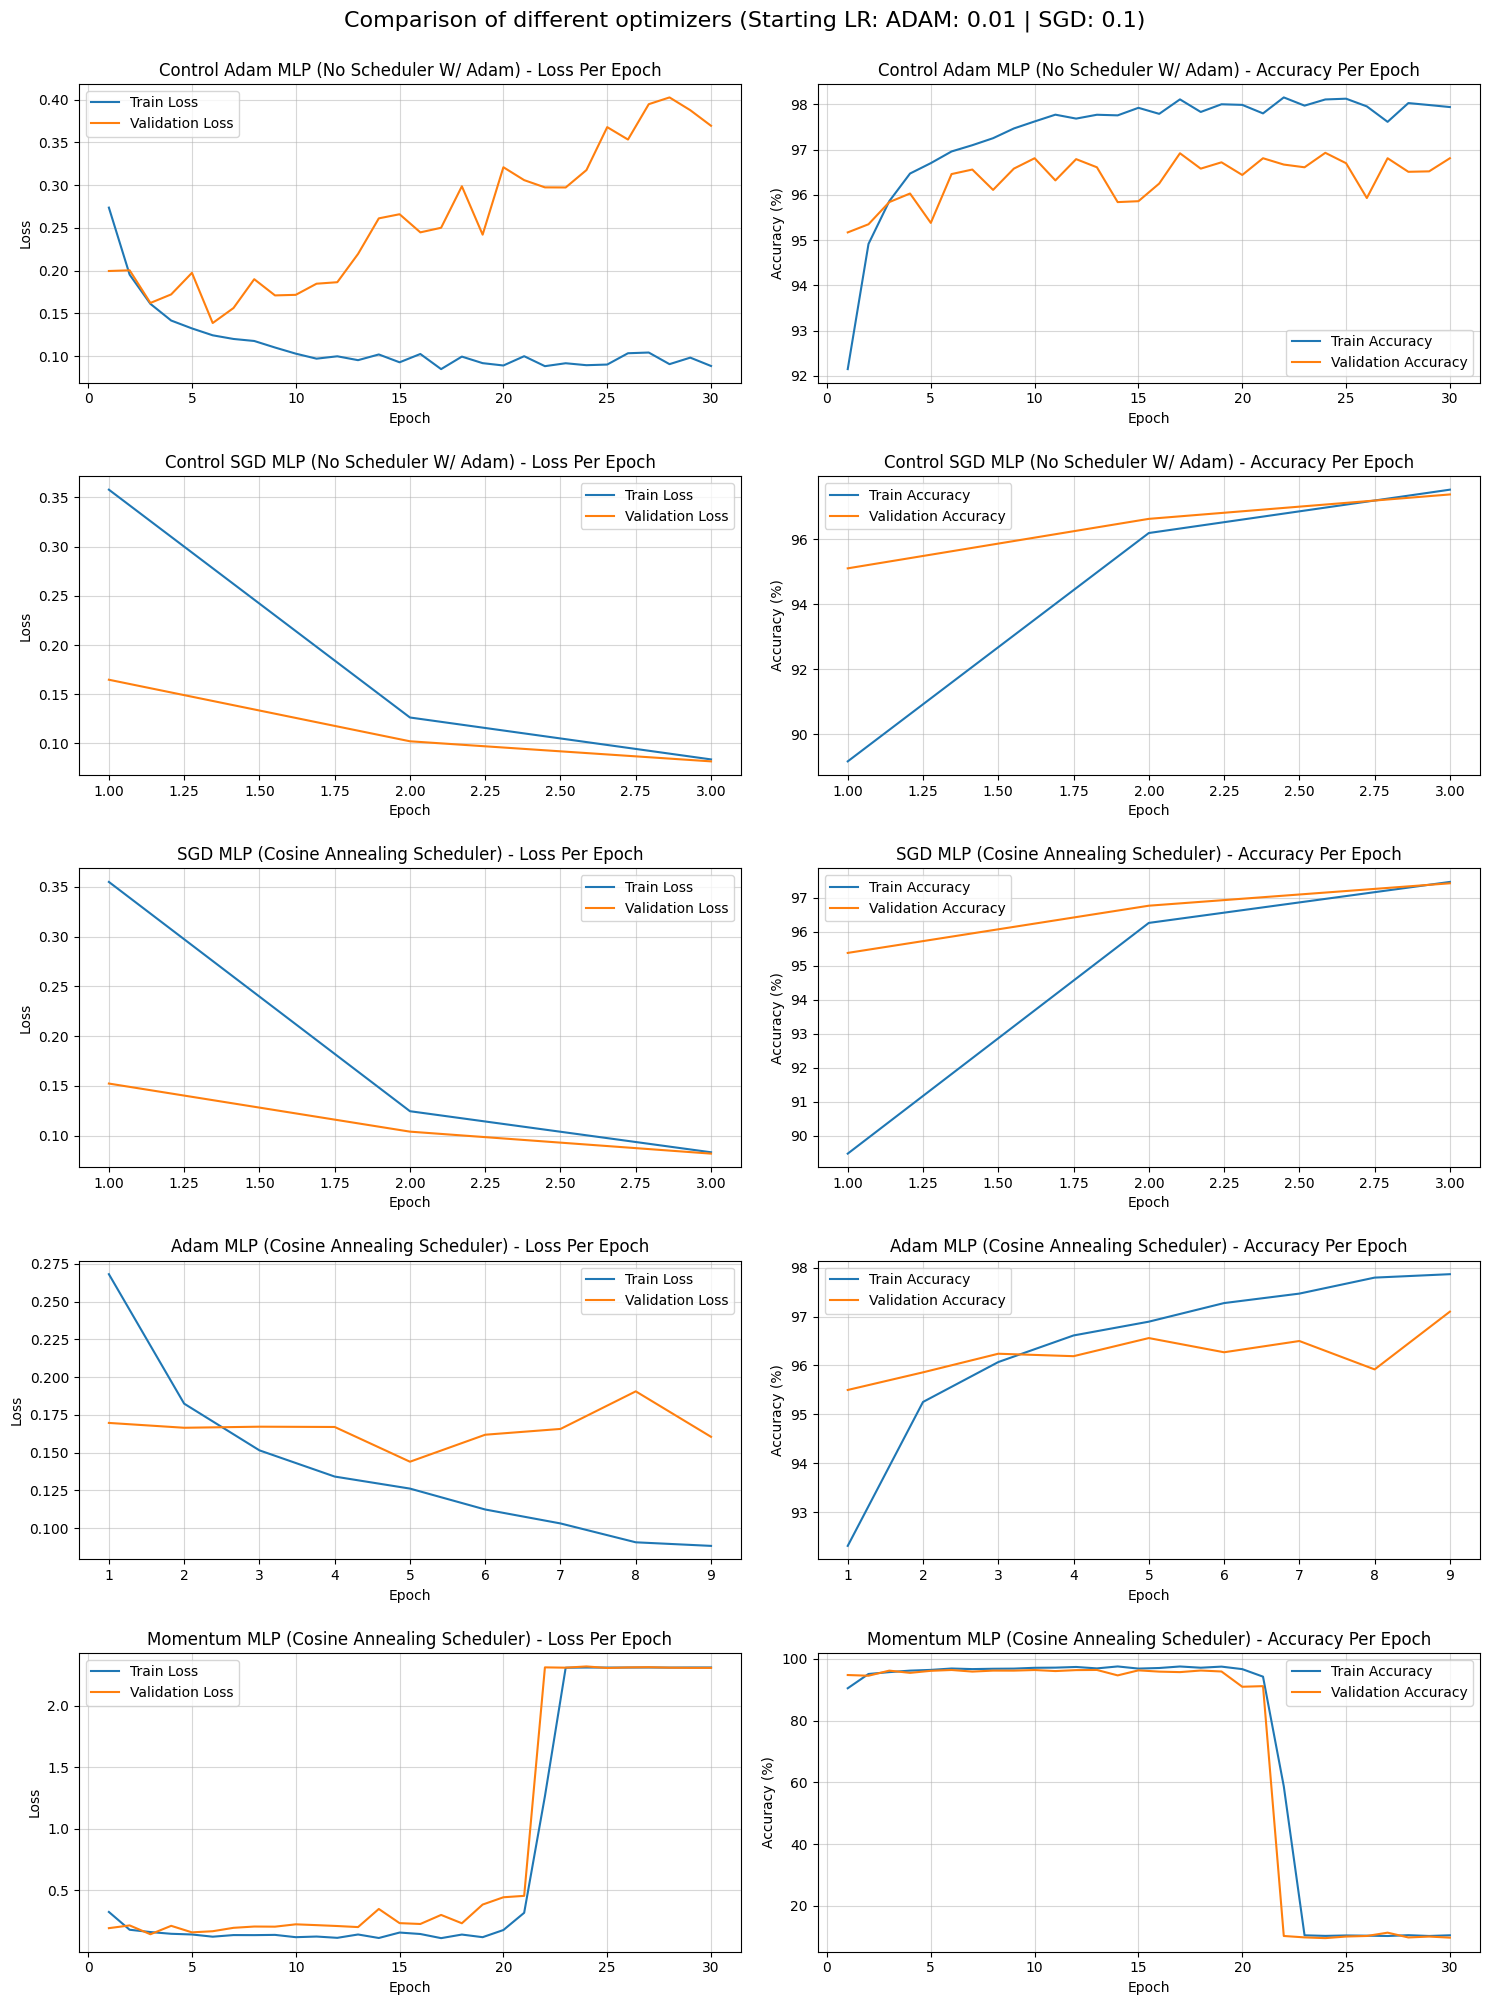

In [10]:
# Create figure with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Data to plot (model metrics)
models_data = [
    (control_adam_metrics, "Control Adam MLP (No Scheduler W/ Adam)"),
    (control_sgd_metrics, "Control SGD MLP (No Scheduler W/ Adam)"),
    (sgd_model_metrics, "SGD MLP (Cosine Annealing Scheduler)"),
    (adam_model_metrics, "Adam MLP (Cosine Annealing Scheduler)"),
    (momentum_model_metrics, "Momentum MLP (Cosine Annealing Scheduler)")
]

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"Comparison of different optimizers (Starting LR: ADAM: {LEARNING_RATE_ADAM} | SGD: {LEARNING_RATE_SGD})",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()